In [1]:
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
from transcript_functions import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rawin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
import pdftotext

df = pd.DataFrame(columns = ['raw_text','year'])

for k in range(10,20):
    
    pdfFileObj = open("C:/Users/rawin/Documents/GitHub/Capstone-Project/Proxies/Target/20%s_proxy.pdf"%(k),'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    
    year = "20%s"%(k)
    company = "Target"

    sub_df = pd.DataFrame(columns = ['raw_text','year'])
    for page in pdf:
        x = page.replace('\n \n',', ')
        x = page.replace('\n',' ')
        sub_df = sub_df.append({'raw_text':x,'year':year,'company':company},ignore_index=True)

    df = pd.concat([df,sub_df],ignore_index=True)

In [3]:
df.shape

(832, 3)

In [4]:
#remove numbers
df['raw_text'] =  df['raw_text'].map(lambda x: re.sub(r'\d+', '', x))

stop_words = set(stopwords.words('english'))

punctuations = ['(',')',';',':','[',']',',','.',"''",'$','%','``',"’",".//","”",'-','˜˜','@','?','...']

#tokenize, lower-case, remove stopwords, and remove punctuations
df["tokens_clean"] = df["raw_text"].map(lambda x: [word.lower() for word in word_tokenize(x) 
                                                   if word not in stop_words and word not in punctuations])

In [5]:
# tag Part of Speech
df["tokens_pos"] = df["tokens_clean"].map(nltk.pos_tag)
# filter words with pos not in pos_keep
pos_keep = ["NN", "NNS","VB", "VBD", "VBN", "VBP", "VBZ"] #take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_keep])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_final"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if len(word)>3])

In [6]:
remove_words =['shareholders','board','mr.','director','committee','proxy','meeting',
               'share','vote','shareholder','stock','plan','target']

df["tokens_final"] = df["tokens_final"].map(lambda x: [word for word in x if word.lower() not in remove_words])

In [7]:
#keeping only rows that has more than 3 elements in tokens_final
df = df[df['tokens_final'].apply(lambda x: len(x) > 5)]

In [8]:
target_df = df[['year','company','tokens_final']]

target_df.to_csv(path_or_buf ='C:\\Users\\rawin\\Documents\\GitHub\\Capstone-Project\\Proxies\\All\\target.csv', index = False)

In [9]:
import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import common_corpus, common_dictionary

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [10]:
dictionary = gensim.corpora.Dictionary(df["tokens_final"])

dictionary.filter_extremes(no_below=1, no_above=0.5) #, keep_n=100000)

bow_corpus = [dictionary.doc2bow(word) for word in df["tokens_final"]]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, 
                                       passes=2, workers=2, chunksize=100, random_state=1000)

In [11]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.059*"company" + 0.029*"group" + 0.021*"president" + '
        '0.020*"experience" + 0.019*"peer" + 0.019*"position" + '
        '0.018*"industry" + 0.017*"inc." + 0.016*"management" + 0.016*"serve"'),
    (   1,
        '0.058*"payment" + 0.054*"termination" + 0.030*"employment" + '
        '0.027*"benefit" + 0.022*"table" + 0.019*"amount" + 0.016*"edcp" + '
        '0.016*"participant" + 0.015*"change-in-control" + 0.014*"option"'),
    (   2,
        '0.035*"item" + 0.025*"owner" + 0.020*"proposal" + 0.017*"business" + '
        '0.016*"person" + 0.015*"question" + 0.015*"majority" + 0.015*"time" + '
        '0.013*"register" + 0.013*"effect"'),
    (   3,
        '0.026*"transaction" + 0.015*"member" + 0.015*"name" + 0.014*"number" '
        '+ 0.013*"amount" + 0.011*"person" + 0.010*"group" + 0.010*"receive" + '
        '0.010*"material" + 0.009*"determine"'),
    (   4,
        '0.050*"instruction" + 0.036*"material" + 0.031*"card" + '
        '0.025*"number"

In [12]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

In [13]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.116322  0.117646       1        1  11.018143
13     0.038884 -0.201514       2        1  10.745665
14    -0.023650 -0.085606       3        1   9.664642
7     -0.113389 -0.016553       4        1   9.510399
5     -0.102218  0.013703       5        1   8.286478
1     -0.169404  0.177614       6        1   7.442766
0     -0.050861 -0.209165       7        1   7.299190
11    -0.103959 -0.009985       8        1   6.875591
2      0.206260  0.036989       9        1   5.781507
4      0.286614  0.165251      10        1   5.171054
12    -0.034782 -0.115315      11        1   4.624844
3     -0.008352  0.038302      12        1   4.505887
10    -0.000910  0.126394      13        1   4.076634
6      0.232531 -0.083028      14        1   3.483600
9     -0.040441  0.045267      15        1   1.513599, topic_info=             Term         Freq        Total Category  logprob  loglift
123     ownership   488.000000   488.000000  Default  30.0000  30.0000
712       pension   579.000000   579.000000  Default  29.0000  29.0000
1060  termination   721.000000   721.000000  Default  28.0000  28.0000
213   performance  1743.000000  1743.000000  Default  27.0000  27.0000
26        payment   843.000000   843.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
28         person    15.575940   391.553406  Topic15  -4.6933   0.9663
33        require    13.114064   384.910492  Topic15  -4.8653   0.8114
44          value    14.625084   822.436340  Topic15  -4.7563   0.1611
21           name    13.120707   394.553833  Topic15  -4.8648   0.7871
362      position    12.340519   350.865906  Topic15  -4.9261   0.8432

[1045 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
95        9  0.095023       a.m.
95       10  0.823531       a.m.
862       7  0.776606     abbott
862      11  0.137048     abbott
2295      7  0.122320     abbvie
...     ...       ...        ...
435      11  0.596475  workforce
2307      7  0.915829  worldwide
1119      6  0.863394   year-end
776       4  0.836351       york
959       8  0.807154   —payouts

[4578 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 14, 15, 8, 6, 2, 1, 12, 3, 5, 13, 4, 11, 7, 10])

In [14]:
df.columns

Index(['raw_text', 'year', 'company', 'tokens_clean', 'tokens_pos',
       'tokens_final'],
      dtype='object')

## Finding the dominant topic in each page

In [15]:
def format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']]):
    # Init output
    page_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                page_topics_df = page_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    page_topics_df.columns = ['topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    page_topics_df = pd.concat([texts,page_topics_df], axis=1)
    return(page_topics_df)


df_topic_pages_keywords = format_topics_pages(ldamodel=lda_model, corpus=bow_corpus, texts=df[['year','tokens_final']])

# Format
df_dominant_topic = df_topic_pages_keywords.reset_index()
df_dominant_topic = df_dominant_topic.drop('index',axis=1)

# Show
df_dominant_topic.head(10)

,year,tokens_final,topic,perc_contribution,topic_keywords
0,2010,"[link, review, document, table, content, state...",3.0,0.6709,"transaction, member, name, number, amount, per..."
1,NaN,NaN,4.0,0.8444,"instruction, material, card, number, form, rec..."
2,2010,"[nicollet, mall, minneapolis, minnesota, state...",2.0,0.9073,"item, owner, proposal, business, person, quest..."
3,2010,"[invite, corporation, hold, mountain, time, ju...",4.0,0.9932,"instruction, material, card, number, form, rec..."
4,2010,"[method, statement, describes, issue, corporat...",4.0,0.9151,"instruction, material, card, number, form, rec..."
5,2010,"[notice, availability, material, notice, avail...",2.0,0.8894,"item, owner, proposal, business, person, quest..."
6,2010,"[notice, time, p.m., mountain, daylight, time,...",2.0,0.3309,"item, owner, proposal, business, person, quest..."
7,2010,"[table, content, information, voting, item, on...",2.0,0.8341,"item, owner, proposal, business, person, quest..."
8,2010,"[statement, june, corporation, solicits, enclo...",2.0,0.7070,"item, owner, proposal, business, person, quest..."
9,2010,"[requirement, election, inspector, count, resu...",4.0,0.6814,"instruction, material, card, number, form, rec..."


In [16]:
df_dominant_topic.shape

(830, 5)

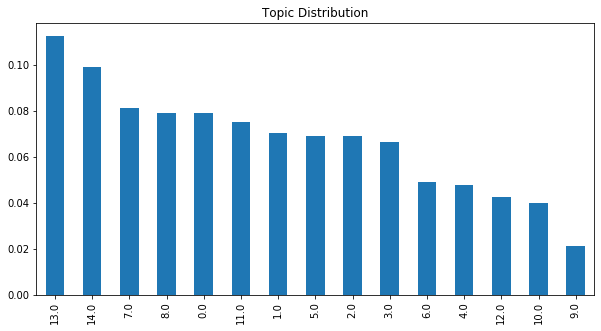

In [17]:
topic_counts = df_dominant_topic["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="Percentage",
                                       title="Topic Distribution",
                                       kind="bar", figsize=(10,5))

## Topic Trends

In [18]:
df_trend = pd.crosstab(df_dominant_topic["year"], df_dominant_topic["topic"], normalize="index")
years = [str(x) for x in df_trend.index]

In [19]:
df_trend

topic,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
year,,,,,,,,,,,,,,,
2010,0.078947,0.105263,0.078947,0.171053,0.052632,0.039474,0.078947,0.078947,0.065789,0.013158,0.039474,0.039474,0.026316,0.052632,0.078947
2011,0.051020,0.061224,0.071429,0.051020,0.040816,0.051020,0.071429,0.102041,0.234694,0.010204,0.030612,0.071429,0.020408,0.040816,0.091837
2012,0.064935,0.064935,0.064935,0.090909,0.038961,0.064935,0.077922,0.064935,0.103896,0.012987,0.038961,0.064935,0.025974,0.064935,0.155844
2013,0.098765,0.074074,0.049383,0.086420,0.024691,0.086420,0.037037,0.074074,0.049383,0.024691,0.074074,0.086420,0.024691,0.086420,0.123457
2014,0.089744,0.076923,0.089744,0.064103,0.038462,0.102564,0.025641,0.064103,0.012821,0.025641,0.051282,0.089744,0.064103,0.153846,0.051282
2015,0.050505,0.060606,0.070707,0.030303,0.040404,0.080808,0.020202,0.080808,0.181818,0.020202,0.030303,0.060606,0.050505,0.141414,0.080808
2016,0.106667,0.066667,0.066667,0.040000,0.053333,0.040000,0.026667,0.080000,0.026667,0.026667,0.040000,0.066667,0.053333,0.146667,0.160000
2017,0.088235,0.073529,0.073529,0.044118,0.058824,0.058824,0.029412,0.088235,0.029412,0.000000,0.014706,0.088235,0.073529,0.161765,0.117647
2018,0.108108,0.054054,0.054054,0.040541,0.054054,0.094595,0.027027,0.067568,0.000000,0.027027,0.054054,0.081081,0.054054,0.202703,0.081081


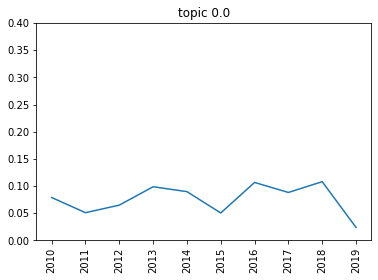

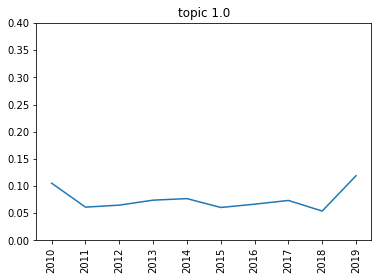

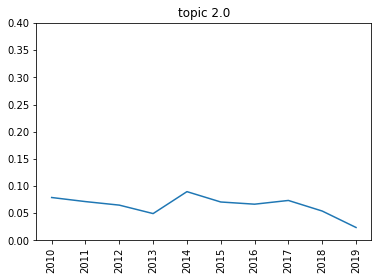

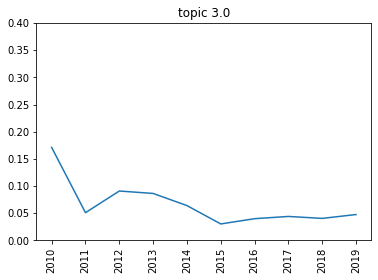

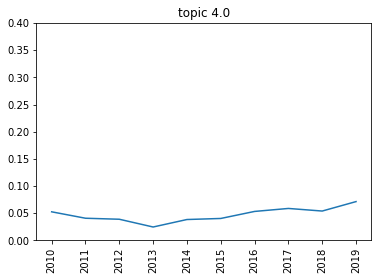

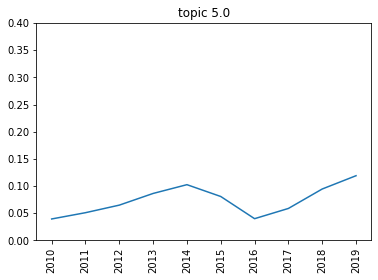

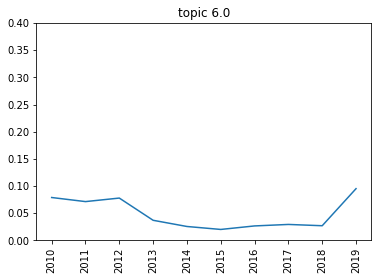

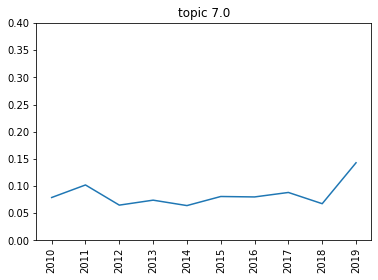

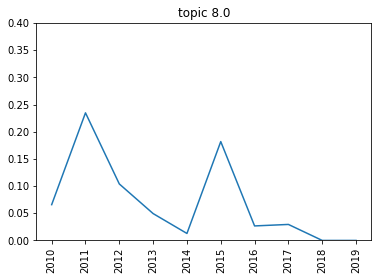

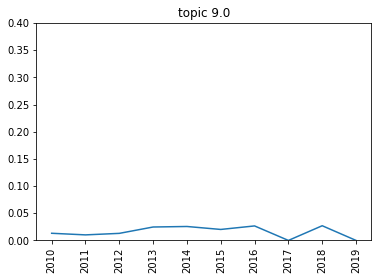

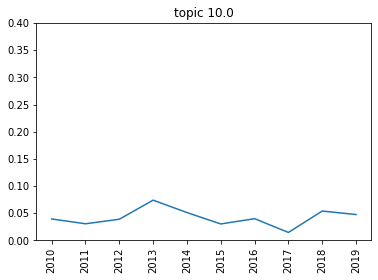

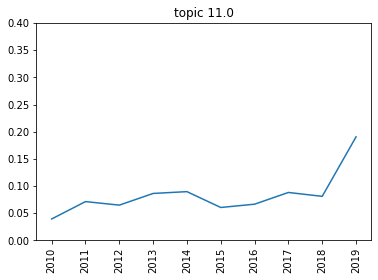

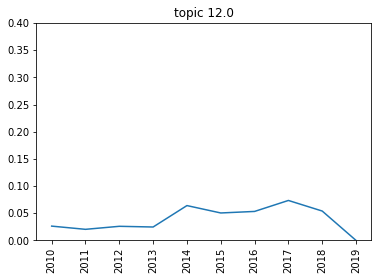

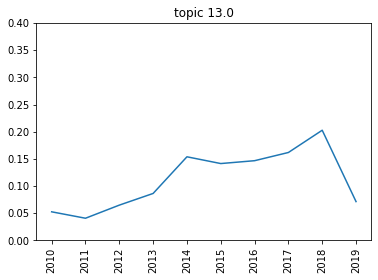

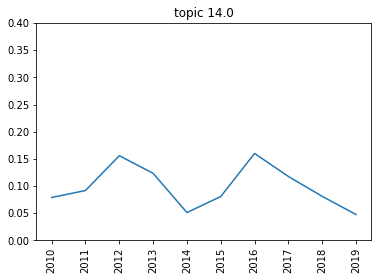

In [20]:
for topic in df_trend:
    fig, ax = plt.subplots()
    plt.plot(years, df_trend[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))